# Bibliotecas Utilizadas

In [1]:
# Bibliotecas utilizadas e configurações
from time import time

# Plotagens
import matplotlib.pyplot as plt

# Manipulação das imagens e datasets
import numpy as np
import pandas as pd
from PIL import Image

# Particionamento de dados e métricas
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


# Modelo de CNN, utilizando Keras
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image

# Redução de dimensionalidade
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV

# Modelo SVC
from sklearn.svm import SVC

# Manipulação de pastas
import os
import shutil

# Ordenação de listas
from collections import OrderedDict

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

t0 = time()

In [2]:
# Parâmetros globais
n_classes = 7

# Funções

In [3]:
# Exibe a distribuição de imagens por celebridade 
def show_dist(names, limit):
    print(names.value_counts()[:limit])
    names.value_counts()[:limit].plot(kind="bar", title="Distribuição imagens por celebridade")

In [4]:
# Exibe uma imagem
def show_img(img_path, title):
    im = Image.open("lfw-deepfunneled/lfw-deepfunneled/" + str(img_path))
    plt.title(title)
    plt.imshow(im)
    plt.axis('off')
    plt.show()

In [5]:
# Copia as imagens informadas para uma pasta, usado para distribuir as imagens para as pastas de treino e teste
def copy_to_directory(data, dir_name):
    count = 0
    for image in data.image_path:
        # create top directory
        if not os.path.exists(dir_name):
            shutil.os.mkdir(dir_name)
        
        data_type = data[data['image_path'] == image]['name']
        data_type = str(list(data_type)[0])
        if not os.path.exists(os.path.join(dir_name, data_type)):
            shutil.os.mkdir(os.path.join(dir_name, data_type))
        path_from = os.path.join('lfw-deepfunneled/lfw-deepfunneled/',image)
        path_to = os.path.join(dir_name, data_type)
        
        shutil.copy(path_from, path_to)
        count += 1
        
    print('{} imagens copiadas para a pasta {}.'.format(count, dir_name))

In [6]:
# Função para predizer as classes (celebridades) a partir de um diretório de 
# testes e do classificador já treinado
def predict(dir_name, classifier):
    predictions = []
    for im in os.listdir(dir_name):
        test_image = image.load_img(dir_name + str(im), target_size = (250,250))
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis = 0)
        result = np.argmax(classifier.predict(test_image))
        predictions.append(result)
    return(predictions)

In [7]:
# Calcula as métricas do classificador
def calc_metrics(predictions_frame):
    precision = []
    accuracy = []
    recall = []
    f1_score = []
    total_preds = predictions_frame.shape[0]

    for i in range(len(set(predictions_frame.Predito))):
        precision_i = 0
        recall_i = 0
        f1_score_i = 0
        
        tp = predictions_frame[np.logical_and(predictions_frame['Real'] == i, 
                                              predictions_frame['Predito'] == i)].shape[0]
        tn = predictions_frame[np.logical_and(predictions_frame['Real'] != i, 
                                              predictions_frame['Predito'] != i)].shape[0]
        fp = predictions_frame[np.logical_and(predictions_frame['Real'] != i, 
                                              predictions_frame['Predito'] == i)].shape[0]
        fn = predictions_frame[np.logical_and(predictions_frame['Real'] == i, 
                                              predictions_frame['Predito'] != i)].shape[0]
        # Acurácia
        accuracy.append((tp + tn)/total_preds)
        
        # Precisão
        if tp + fp > 0:
            precision_i = round(tp/(tp + fp), 2)
        precision.append(precision_i)
        
        # Recall
        if tp + fn > 0:
            recall_i = round(tp/(tp + fn), 2)
        recall.append(recall_i)
        
        # F1-score = 2*precisao*recall/(precisao+recall)
        if precision_i + recall_i > 0:
            f1_score_i = round(2*precision_i*recall_i/(precision_i+recall_i), 2)
        f1_score.append(f1_score_i)
            
    return(accuracy, precision, recall, f1_score)

# Coleta e Preparação dos Dados

In [8]:
# Inicia o dataframe de imagens para conter o nome da personalidade e o caminho para as suas imagens
# Uma imagem por linha
lfw_allnames = pd.read_csv("lfw_allnames.csv")
image_paths = lfw_allnames.loc[lfw_allnames.index.repeat(lfw_allnames['images'])]
image_paths['image_path'] = 1 + image_paths.groupby('name').cumcount()
image_paths['image_path'] = image_paths.image_path.apply(lambda x: '{0:0>4}'.format(x))
image_paths['image_path'] = image_paths.name + "/" + image_paths.name + "_" + image_paths.image_path + ".jpg"
image_paths = image_paths.drop("images",1)
image_paths

,name,image_path
0,AJ_Cook,AJ_Cook/AJ_Cook_0001.jpg
1,AJ_Lamas,AJ_Lamas/AJ_Lamas_0001.jpg
2,Aaron_Eckhart,Aaron_Eckhart/Aaron_Eckhart_0001.jpg
3,Aaron_Guiel,Aaron_Guiel/Aaron_Guiel_0001.jpg
4,Aaron_Patterson,Aaron_Patterson/Aaron_Patterson_0001.jpg
...,...,...
5744,Zorica_Radovic,Zorica_Radovic/Zorica_Radovic_0001.jpg
5745,Zulfiqar_Ahmed,Zulfiqar_Ahmed/Zulfiqar_Ahmed_0001.jpg
5746,Zumrati_Juma,Zumrati_Juma/Zumrati_Juma_0001.jpg
5747,Zurab_Tsereteli,Zurab_Tsereteli/Zurab_Tsereteli_0001.jpg


George_W_Bush        530
Colin_Powell         236
Tony_Blair           144
Donald_Rumsfeld      121
Gerhard_Schroeder    109
Ariel_Sharon          77
Hugo_Chavez           71
Name: name, dtype: int64


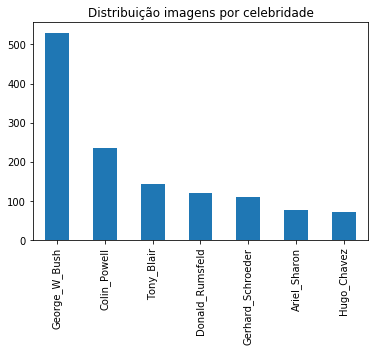

In [9]:
# Distribuição original de imagens por celebridade
show_dist(image_paths['name'], n_classes)

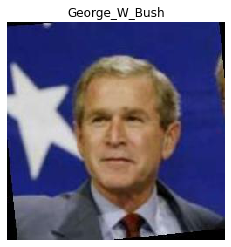

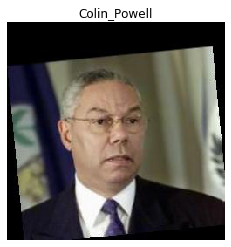

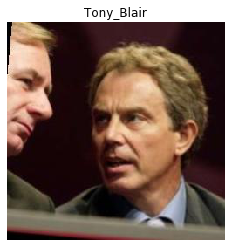

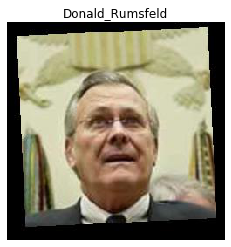

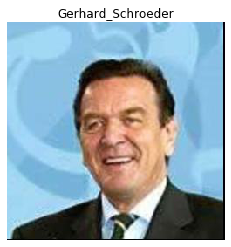

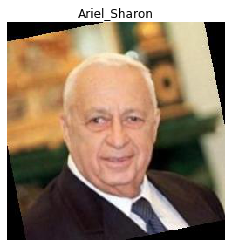

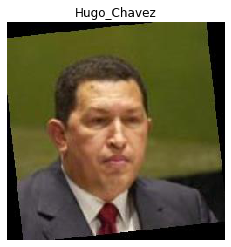

In [10]:
# Exibe as imagens das celebridades que serão submetidas ao treino
target_names = list(image_paths.name.value_counts()[:n_classes].index)

for name in target_names:
    show_img(image_paths.image_path[image_paths.name == name].iloc[0], name)

Colin_Powell         71
Donald_Rumsfeld      71
Gerhard_Schroeder    71
Hugo_Chavez          71
George_W_Bush        71
Tony_Blair           71
Ariel_Sharon         71
Name: name, dtype: int64


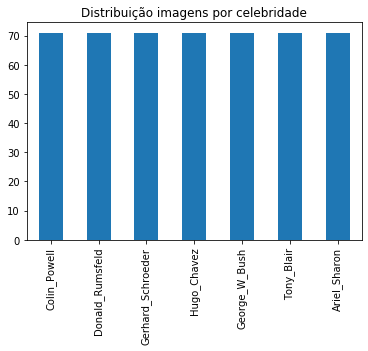

In [11]:
# Como a distribuição original é desbalanceada, é feita uma amostra de um 
# número fixo de imagens por celebridade, aproveitando-se as celebridades que tem 
# o maior número de imagens, obtendo-se um dataset balanceado

# O número de amostras por classe é definido como o número de imagens da 
# personalidade que possui menos imagens
# No caso, o último do value_counts dos nomes
class_samples = image_paths.name.value_counts()[:n_classes][-1]
multi_data = pd.DataFrame([], columns=['name', 'image_path'])

for name in target_names:
    multi_data = pd.concat([multi_data, image_paths[image_paths.name==name]
                            .sample(class_samples)])

show_dist(multi_data['name'], n_classes)

# Modelo de Reconhecimento de Rosto Utilizando SVC

In [12]:
# Preprocessamento das imagens: cria um dataset das features (X) no formato 
# para treinamento com SVC
X = np.zeros((len(multi_data), 62500)) 

for i, path in enumerate(multi_data.image_path):
    img = Image.open("lfw-deepfunneled/lfw-deepfunneled/" + path).convert('L')
    img_array = np.array(img.getdata()).reshape(img.size[0], img.size[1], 1)
    flattened = img_array.flatten()
    X[i] = flattened

n_features = X.shape[1]
print("Número de features: %d" % n_features)
print("Dimensões X: {}".format(X.shape))

Número de features: 62500
Dimensões X: (497, 62500)


In [13]:
# Gera o vetor de rótulos (y) e os nomes das celebridades correspondentes
y = np.zeros(len(multi_data))

for i, name in enumerate(multi_data.name):
    y[i] = target_names.index(name)
    
print("Dimensões y: {}".format(y.shape))

Dimensões y: (497,)


In [14]:
# Divisão em dados de treinamento e de teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2)

print("Dimensões treinamento: {}".format(X_train.shape) )
print("Dimensões teste: {}".format(X_test.shape))

Dimensões treinamento: (397, 62500)
Dimensões teste: (100, 62500)


In [15]:
# Aplica a técnica PCA para redução de dimensionalidade da imagem
n_components = 300

print("Extraindo os %d componentes mais importantes de %d parâmetros originais"
      % (n_components, X_train.shape[1]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("Concluído em %0.3fs" % (time() - t0))

print("Aplicando PCA nos dados de treinamento e de teste")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("Concluído em %0.3fs" % (time() - t0))

Extraindo os 300 componentes mais importantes de 62500 parâmetros originais
Concluído em 4.255s
Aplicando PCA nos dados de treinamento e de teste
Concluído em 0.276s


In [16]:
# Treino do modelo de classificação, utilizando SVM
print("Treinando o classificador")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced'), param_grid
)
clf = clf.fit(X_train_pca, y_train)
print("Concluído em %0.3fs" % (time() - t0))
print("Parâmetros encontrados pelo Grid Search:")
print(clf.best_estimator_)

Treinando o classificador
Concluído em 6.479s
Parâmetros encontrados pelo Grid Search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0005, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [17]:
# Análise quantitativa do modelo SVC
y_pred = clf.predict(X_test_pca).astype(int)

print("Matriz de Confusão")
c_matrix = confusion_matrix(y_test, y_pred, labels=range(n_classes))
print(c_matrix)

Matriz de Confusão
[[ 4  0  1  2  2  0  1]
 [ 1  9  0  0  1  2  0]
 [ 2  0 15  0  1  1  0]
 [ 1  0  1 15  1  0  0]
 [ 2  1  2  1  8  0  1]
 [ 1  0  0  0  0 12  0]
 [ 2  0  0  1  2  0  7]]


In [18]:
# Monta uma tabela contendo um registro correspondente para cada linha do conjunto de teste
# Cada linha contem a classe predito e a verdadeira
predictions_frame = pd.DataFrame(list(zip(y_pred, y_test)), columns = ['Predito','Real'])
predictions_frame

,Predito,Real
0,6,6.0
1,0,4.0
2,2,2.0
3,3,0.0
4,1,1.0
...,...,...
95,2,2.0
96,5,5.0
97,0,2.0
98,3,3.0


In [19]:
# Cálculo e exibição das métricas
multi_metrics = calc_metrics(predictions_frame)

metrics = pd.DataFrame(list(zip(target_names, multi_metrics[0], multi_metrics[1], multi_metrics[2], multi_metrics[3])),
                      columns = ['Nome','Acuracia', 'Precisao', 'Recall', 'F1-score'])

print('Acurácia geral: {}'.format(round(metrics.Acuracia.mean(), 2)))

metrics

Acurácia geral: 0.91


,Nome,Acuracia,Precisao,Recall,F1-score
0,George_W_Bush,0.85,0.31,0.40,0.35
1,Colin_Powell,0.95,0.90,0.69,0.78
2,Tony_Blair,0.92,0.79,0.79,0.79
3,Donald_Rumsfeld,0.93,0.79,0.83,0.81
4,Gerhard_Schroeder,0.86,0.53,0.53,0.53
5,Ariel_Sharon,0.96,0.80,0.92,0.86
6,Hugo_Chavez,0.93,0.78,0.58,0.67


# Modelo de Reconhecimento de Rosto Utilizando CNN

In [20]:
# Divisão dos dados em treino e teste
multi_train, multi_test = train_test_split(multi_data, test_size=0.2)

print('Dados de treino: {}'.format(multi_train.shape[0]))
print('Dados de teste: {}'.format(multi_test.shape[0]))

Dados de treino: 397
Dados de teste: 100


In [21]:
# Deleta as pastas de treino e teste para nova interação
if "train_multi" in os.listdir("./"):
    shutil.rmtree("./train_multi")

if "test_multi" in os.listdir("./"):
    shutil.rmtree("./test_multi")

In [22]:
# Copia as imagens para as respectivas pastas de treino e teste
copy_to_directory(multi_train,"train_multi/")

copy_to_directory(multi_test,"test_multi/")

397 imagens copiadas para a pasta train_multi/.
100 imagens copiadas para a pasta test_multi/.


In [23]:
# Define o conjunto de dados de treino e teste, prontos para treinamento
# Aplica randomicamente algumas transformações nas imagens
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True)

test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

multi_training_set = train_datagen.flow_from_directory('train_multi/',
                                                 target_size = (250, 250),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')


multi_test_set = test_datagen.flow_from_directory('test_multi/',
                                            target_size = (250, 250),
                                            batch_size = 32,
                                            class_mode = 'categorical')



Found 397 images belonging to 7 classes.
Found 100 images belonging to 7 classes.


In [24]:
# Definição do modelo
multi_classifier = Sequential()

multi_classifier.add(Conv2D(32, (3, 3), input_shape = (250, 250, 3), 
                            activation = 'relu'))
multi_classifier.add(MaxPooling2D(pool_size = (2, 2)))

multi_classifier.add(Flatten())

multi_classifier.add(Dense(units = 128, activation = 'relu'))

# Número de unidades de saída igual ao número de classes
# Função de ativação recomendada para classificação: softmax 
multi_classifier.add(Dense(units = n_classes, activation = 'softmax'))

# Função loss recomendada: categorical_crossentropy
multi_classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', 
                         metrics = ['accuracy'])

In [25]:
# Treinamento do modelo
t1 = time()
multi_history = multi_classifier.fit_generator(multi_training_set,
                                               epochs = 50
                                              )
tempo_minutos = int((time() - t1)/60)
tempo_segundos = (time() - t1)%60
print("Concluído em: {} minutos {} segundos".format(tempo_minutos, round(tempo_segundos, 2)))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
13/13 [==============================] - 19s 1s/step - loss: 22.7830 - accuracy: 0.1335
Epoch 2/50
13/13 [==============================] - 18s 1s/step - loss: 3.1801 - accuracy: 0.2242
Epoch 3/50
13/13 [==============================] - 17s 1s/step - loss: 2.0893 - accuracy: 0.2317
Epoch 4/50
13/13 [==============================] - 16s 1s/step - loss: 1.7609 - accuracy: 0.2972
Epoch 5/50
13/13 [==============================] - 12s 926ms/step - loss: 1.6892 - accuracy: 0.3501
Epoch 6/50
13/13 [==============================] - 12s 925ms/step - loss: 1.5441 - accuracy: 0.4106
Epoch 7/50
13/13 [==============================] - 12s 929ms/step - loss: 1.4872 - accuracy: 0.4458
Epoch 8/50
13/13 [==============================] - 13s 966ms/step - loss: 1.3400 - accuracy: 0.5315
Epoch 9/50
13/13 [==============================] - 11s 853ms/step - loss: 1.3268 - accuracy: 0.5491
Epoch 10/50
13/13 [=======

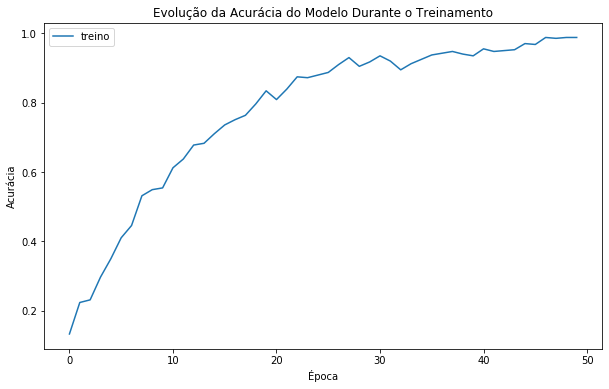

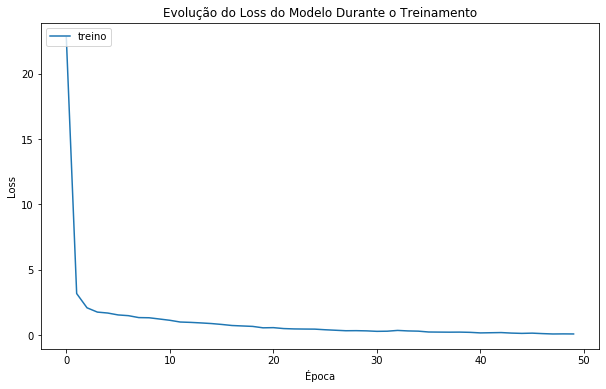

In [26]:
# Análise do treinamento
# Acucária
plt.figure(figsize=(10, 6))
plt.plot(multi_history.history['accuracy'])
plt.title('Evolução da Acurácia do Modelo Durante o Treinamento')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['treino', 'validação'], loc='upper left')
plt.show()

# Função loss
plt.figure(figsize=(10, 6))
plt.plot(multi_history.history['loss'])
plt.title('Evolução do Loss do Modelo Durante o Treinamento')
plt.ylabel('Loss')
plt.xlabel('Época')
plt.legend(['treino', 'validação'], loc='upper left')
plt.show()

In [27]:
# Obtem o nome das classes na ordem que elas foram passadas para o treinamento
multi_test_names = []

for i in range(len(multi_test_set.filenames)):
    multi_test_names.append(multi_test_set.filenames[i])

for i in range(len(multi_test_names)):
    multi_test_names[i] = multi_test_names[i].split("/")[0]
multi_test_name_order = list(OrderedDict.fromkeys(multi_test_names))

multi_test_name_order

['Ariel_Sharon',
 'Colin_Powell',
 'Donald_Rumsfeld',
 'George_W_Bush',
 'Gerhard_Schroeder',
 'Hugo_Chavez',
 'Tony_Blair']

In [28]:
# Realiza a predição do classificador para cada classe, a partir do conjunto de teste
# e monta o vetor de respostas (target)
predictions = []
target = []

for i, name in enumerate(multi_test_name_order):
    class_predictions = predict("test_multi/" + name + "/", multi_classifier)
    predictions.extend(class_predictions)
    class_target = [i] * len(class_predictions)
    target.extend(class_target)

# Monta uma tabela contendo um registro correspondente para cada linha do conjunto de teste
# Cada linha contem a classe predito e a verdadeira
predictions_frame = pd.DataFrame(list(zip(predictions, target)), columns = ['Predito','Real'])
predictions_frame

,Predito,Real
0,0,0
1,0,0
2,6,0
3,2,0
4,0,0
...,...,...
95,0,6
96,6,6
97,6,6
98,3,6


In [29]:
# Cálculo e exibição das métricas
multi_metrics = calc_metrics(predictions_frame)

metrics = pd.DataFrame(list(zip(multi_test_name_order, multi_metrics[0], multi_metrics[1], multi_metrics[2], multi_metrics[3])),
                      columns = ['Nome','Acuracia', 'Precisao', 'Recall', 'F1-score'])

print('Acurácia geral: {}'.format(round(metrics.Acuracia.mean(), 2)))

metrics

Acurácia geral: 0.9


,Nome,Acuracia,Precisao,Recall,F1-score
0,Ariel_Sharon,0.93,0.58,0.78,0.67
1,Colin_Powell,0.94,1.00,0.57,0.73
2,Donald_Rumsfeld,0.94,0.76,0.87,0.81
3,George_W_Bush,0.85,0.45,0.77,0.57
4,Gerhard_Schroeder,0.91,0.73,0.57,0.64
5,Hugo_Chavez,0.90,0.80,0.63,0.70
6,Tony_Blair,0.85,0.53,0.50,0.51


In [30]:
# Deleta as pastas de treino e teste para nova interação
if "train_multi" in os.listdir("./"):
    shutil.rmtree("./train_multi")

if "test_multi" in os.listdir("./"):
    shutil.rmtree("./test_multi")

In [31]:
tempo_minutos = int((time() - t0)/60)
tempo_segundos = (time() - t0)%60
print("Tempo total decorrido na execução de todo o script: {} minutos {} segundos".format(tempo_minutos, round(tempo_segundos, 2)))

Tempo total decorrido na execução de todo o script: 11 minutos 10.97 segundos
